`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())
print(f'COLAB={COLAB}')

COLAB=False


In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/Klinjin/WL_ML.git
    # move to the HEP starting kit folder
    %cd WL_ML/

# 0 - Imports & Settings

In [1]:
import os
import json
import time
import zipfile
import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Utility

In [2]:
class Utility:
    @staticmethod
    def add_noise(data, mask, ng, pixel_size=2.):
        """
        Add noise to a noiseless convergence map.

        Parameters
        ----------
        data : np.array
            Noiseless convergence maps.
        mask : np.array
            Binary mask map.
        ng : float
            Number of galaxies per arcmin². This determines the noise level; a larger number means smaller noise.
        pixel_size : float, optional
            Pixel size in arcminutes (default is 2.0).
        """

        return data + np.random.randn(*data.shape) * 0.4 / (2*ng*pixel_size**2)**0.5 * mask

    @staticmethod
    def load_np(data_dir, file_name):
        file_path = os.path.join(data_dir, file_name)
        return np.load(file_path)

    @staticmethod
    def save_np(data_dir, file_name, data):
        file_path = os.path.join(data_dir, file_name)
        np.save(file_path, data)

    @staticmethod
    def save_json_zip(submission_dir, json_file_name, zip_file_name, data):
        """
        Save a dictionary with 'means' and 'errorbars' into a JSON file,
        then compress it into a ZIP file inside submission_dir.

        Parameters
        ----------
        submission_dir : str
            Path to the directory where the ZIP file will be saved.
        file_name : str
            Name of the ZIP file (without extension).
        data : dict
            Dictionary with keys 'means' and 'errorbars'.

        Returns
        -------
        str
            Path to the created ZIP file.
        """
        os.makedirs(submission_dir, exist_ok=True)

        json_path = os.path.join(submission_dir, json_file_name)

        # Save JSON file
        with open(json_path, "w") as f:
            json.dump(data, f)

        # Path to ZIP
        zip_path = os.path.join(submission_dir, zip_file_name)

        # Create ZIP containing only the JSON
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            zf.write(json_path, arcname=json_file_name)

        # Remove the standalone JSON after zipping
        os.remove(json_path)

        return zip_path

### Data

In [4]:
class Data:
    def __init__(self, data_dir, USE_PUBLIC_DATASET):
        self.USE_PUBLIC_DATASET = USE_PUBLIC_DATASET
        self.data_dir = data_dir
        self.mask_file = 'WIDE12H_bin2_2arcmin_mask.npy'
        self.viz_label_file = 'label.npy'

        if self.USE_PUBLIC_DATASET:
            self.kappa_file = 'WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = self.viz_label_file
            self.Ncosmo = 101  # Number of cosmologies in the entire training data
            self.Nsys = 256    # Number of systematic realizations in the entire training data
            self.test_kappa_file = 'WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 4000  # Number of instances in the test data
        else:
            self.kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa.npy'
            self.label_file = 'sampled_label.npy'
            self.Ncosmo = 3    # Number of cosmologies in the sampled training data
            self.Nsys = 30     # Number of systematic realizations in the sampled training data
            self.test_kappa_file = 'sampled_WIDE12H_bin2_2arcmin_kappa_noisy_test.npy'
            self.Ntest = 3     # Number of instances in the sampled test data

        self.shape = [1424,176] # dimensions of each map
        self.pixelsize_arcmin = 2 # pixel size in arcmin
        self.pixelsize_radian = self.pixelsize_arcmin / 60 / 180 * np.pi # pixel size in radian
        self.ng = 30  # galaxy number density. This determines the noise level of the experiment. Do not change this number.
        self.mask = Utility.load_np(data_dir=self.data_dir, file_name=self.mask_file) # A binary map that shows which parts of the sky are observed and which areas are blocked
        self.label = Utility.load_np(data_dir=self.data_dir, file_name=self.label_file) # Training labels (cosmological and physical paramameters) of each training map
        self.viz_label = Utility.load_np(data_dir=self.data_dir, file_name=self.viz_label_file) # For visualization of parameter distributions

    def load_train_data(self):
        self.kappa = np.zeros((self.Ncosmo, self.Nsys, *self.shape), dtype=np.float16)
        self.kappa[:,:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.kappa_file) # Training convergence maps

    def load_test_data(self):
        self.kappa_test = np.zeros((self.Ntest, *self.shape), dtype=np.float16)
        self.kappa_test[:,self.mask] = Utility.load_np(data_dir=self.data_dir, file_name=self.test_kappa_file) # Test noisy convergence maps

### Visualization

In [5]:
class Visualization:

    @staticmethod
    def plot_mask(mask):
        plt.figure(figsize=(30,100))
        plt.imshow(mask.T)
        plt.show()

    @staticmethod
    def plot_noiseless_training_convergence_map(kappa):
        plt.figure(figsize=(30,100))
        plt.imshow(kappa[0,0].T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_noisy_training_convergence_map(kappa, mask, pixelsize_arcmin, ng):
        plt.figure(figsize=(30,100))
        plt.imshow(Utility.add_noise(kappa[0,0], mask, ng, pixelsize_arcmin).T, vmin=-0.02, vmax=0.07)
        plt.show()

    @staticmethod
    def plot_cosmological_parameters_OmegaM_S8(label):
        plt.scatter(label[:,0,0], label[:,0,1])
        plt.xlabel(r'$\Omega_m$')
        plt.ylabel(r'$S_8$')
        plt.show()

    @staticmethod
    def plot_baryonic_physics_parameters(label):
        plt.scatter(label[0,:,2], label[0,:,3])
        plt.xlabel(r'$T_{\mathrm{AGN}}$')
        plt.ylabel(r'$f_0$')
        plt.show()

    @staticmethod
    def plot_photometric_redshift_uncertainty_parameters(label):
        plt.hist(label[0,:,4], bins=20)
        plt.xlabel(r'$\Delta z$')
        plt.show()

### Scoring function

In [6]:
class Score:
    @staticmethod
    def _score_phase1(true_cosmo, infer_cosmo, errorbar):
        """
        Computes the log-likelihood score for Phase 1 based on predicted cosmological parameters.

        Parameters
        ----------
        true_cosmo : np.ndarray
            Array of true cosmological parameters (shape: [n_samples, n_params]).
        infer_cosmo : np.ndarray
            Array of inferred cosmological parameters from the model (same shape as true_cosmo).
        errorbar : np.ndarray
            Array of standard deviations (uncertainties) for each inferred parameter
            (same shape as true_cosmo).

        Returns
        -------
        np.ndarray
            Array of scores for each sample (shape: [n_samples]).
        """

        sq_error = (true_cosmo - infer_cosmo)**2
        scale_factor = 1000  # This is a constant that scales the error term.
        score = - np.sum(sq_error / errorbar**2 + np.log(errorbar**2) + scale_factor * sq_error, 1)
        score = np.mean(score)
        if score >= -10**6: # Set a minimum of the score (to properly display on Codabench)
            return score
        else:
            return -10**6

# 2 - Load train and test data

In [7]:
root_dir = os.getcwd()
print("Root directory is", root_dir)

Root directory is /pscratch/sd/l/lindajin/WL_ML


In [8]:
USE_PUBLIC_DATASET = True

# USE_PUBLIC_DATASET = True
PUBLIC_DATA_DIR = os.path.join(root_dir, 'input_data/')  # This is only required when you set USE_PUBLIC_DATASET = True

In [9]:
if not USE_PUBLIC_DATASET:                                         # Testing this startking kit with a tiny sample of the training data (3, 30, 1424, 176)
    DATA_DIR = os.path.join(root_dir, 'input_data/')
else:                                                              # Training your model with all training data (101, 256, 1424, 176)
    DATA_DIR = PUBLIC_DATA_DIR

### Load the train and test data

In [10]:
# Initialize Data class object
data_obj = Data(data_dir=DATA_DIR, USE_PUBLIC_DATASET=USE_PUBLIC_DATASET)

# # Load train data
# data_obj.load_train_data()

# Load test data
data_obj.load_test_data()

In [11]:
Ncosmo = data_obj.Ncosmo
Nsys = data_obj.Nsys
ng = data_obj.ng

print(f'There are {Ncosmo} cosmological models, each has {Nsys} realizations of nuisance parameters in the training data.')
print(f'We assume a galaxy number density of {ng} per arcmin², which determines the noise level of the experiment.')

There are 101 cosmological models, each has 256 realizations of nuisance parameters in the training data.
We assume a galaxy number density of 30 per arcmin², which determines the noise level of the experiment.


In [63]:
print(f'Shape of the training data = {data_obj.kappa.shape}')
print(f'Shape of the mask = {data_obj.mask.shape}')
print(f'Shape of the training label = {data_obj.label.shape}')
print(f'Shape of the test data = {data_obj.kappa_test.shape}')

Shape of the training data = (101, 256, 1424, 176)
Shape of the mask = (1424, 176)
Shape of the training label = (101, 256, 5)
Shape of the test data = (4000, 1424, 176)


In [64]:
# Add the pixel-level noise to the training set (note that this may take some time and large memory) ~140 GB

np.random.seed(31415)  # Fix the random seed for reproducible results
noisy_kappa = Utility.add_noise(data=data_obj.kappa.astype(np.float64),
                                mask=data_obj.mask,
                                ng=data_obj.ng,
                                pixel_size=data_obj.pixelsize_arcmin)

In [65]:
print(f'Shape of the noised data {noisy_kappa.shape}')

Shape of the noised data (101, 256, 1424, 176)


#### ⚠️ NOTE:

If you want to split your own training/validation sets to evaluate your model, we recommend splitting the original training data along `axis = 1` (the 256 realizations of nuisance parameters). This will ensure that there are no intrinsic correlations between the training and validation sets.

In [66]:
# Split the data into training and validation sets

NP_idx = np.arange(Nsys)  # The indices of Nsys nuisance parameter realizations
split_fraction = 0.2      # Set the fraction of data you want to split (between 0 and 1)
seed = 5566               # Define your random seed for reproducible results

train_NP_idx, val_NP_idx = train_test_split(NP_idx, test_size=split_fraction,
                                            random_state=seed)

noisy_kappa_train = noisy_kappa[:, train_NP_idx]      # shape = (Ncosmo, len(train_NP_idx), 1424, 176)
label_train = data_obj.label[:, train_NP_idx]         # shape = (Ncosmo, len(train_NP_idx), 5)
noisy_kappa_val = noisy_kappa[:, val_NP_idx]          # shape = (Ncosmo, len(val_NP_idx), 1424, 176)
label_val = data_obj.label[:, val_NP_idx]             # shape = (Ncosmo, len(val_NP_idx), 5)

Ntrain = label_train.shape[0]*label_train.shape[1]
Nval = label_val.shape[0]*label_val.shape[1]

In [17]:
# print(f'Shape of the split training data = {noisy_kappa_train.shape}')
# print(f'Shape of the split validation data = {noisy_kappa_val.shape}')

# print(f'Shape of the split training labels = {label_train.shape}')
# print(f'Shape of the split validation labels = {label_val.shape}')

In [18]:
# # Save the split data and labels for future usage

# Utility.save_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy",data=noisy_kappa_train)
# Utility.save_np(data_dir=DATA_DIR, file_name="label_train.npy",data=label_train)
# Utility.save_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy",data=noisy_kappa_val)
# Utility.save_np(data_dir=DATA_DIR, file_name="label_val.npy",data=label_val)

In [12]:
# Load the saved split data (if you saved it at DATA_DIR before)

noisy_kappa_train = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_train.npy")
label_train = Utility.load_np(data_dir=DATA_DIR, file_name="label_train.npy")
noisy_kappa_val = Utility.load_np(data_dir=DATA_DIR, file_name="noisy_kappa_val.npy")
label_val = Utility.load_np(data_dir=DATA_DIR, file_name="label_val.npy")

Ntrain = label_train.shape[0]*label_train.shape[1]
Nval = label_val.shape[0]*label_val.shape[1]

In [13]:
# Reshape the data for CNN
X_train = noisy_kappa_train.reshape(Ntrain, *data_obj.shape)
X_val = noisy_kappa_val.reshape(Nval, *data_obj.shape)

# Here, we ignore the nuisance parameters and only keep the 2 cosmological parameters
y_train = label_train.reshape(Ntrain, 5)[:, :2]
y_val = label_val.reshape(Nval, 5)[:, :2]

In [75]:
print(f'Shape of the split training data = {X_train.shape}')
print(f'Shape of the split validation data = {X_val.shape}')

print(f'Shape of the split training labels = {y_train.shape}')
print(f'Shape of the split validation labels = {y_val.shape}')

Shape of the split training data = (20604, 1424, 176)
Shape of the split validation data = (5252, 1424, 176)
Shape of the split training labels = (20604, 2)
Shape of the split validation labels = (5252, 2)


# 4 - Training

In this notebook, we do not fit any predefined summary statistics to the data and perform MCMC. Instead, we estimate the uncertainties directly using the CNN. This is achieved by optimizing a KL divergence objective function using neural network predictions during training. For each 2D map, the CNN will predict its cosmological parameters $(\hat{\Omega}_m, \hat{S}_8)$ and the standard deviations of the joint Gaussian posterior distribution $(\hat{\sigma}_{\Omega_m}, \hat{\sigma}_{S_8})$.

The loss funciton here is a KL divergence objective function defined by
$$
\text{KL Loss}= \frac{1}{N} \sum_i^{N}\left\{\frac{\left(\hat{\Omega}_{m, i}-\Omega_{m, i}^{\text {truth }}\right)^2}{\hat{\sigma}_{\Omega_m, i}^2}+\frac{\left(\hat{S}_{8, i}-S_{8, i}^{\text {truth }}\right)^2}{\hat{\sigma}_{S_8, i}^2}+\log \left(\hat{\sigma}_{\Omega_m, i}^2\right)+\log \left(\hat{\sigma}_{S_8, i}^2\right)\right\}~.
$$

In [14]:

# Define your path for saving the trained model
MODEL_NAME = "ResNetWithAttention_direct_baseline"

class Config:
    IMG_HEIGHT = data_obj.shape[0]
    IMG_WIDTH = data_obj.shape[1]

    # Parameters to predict (Omega_m, S_8)
    NUM_TARGETS = 4

    # Training hyperparameters
    BATCH_SIZE = 64
    EPOCHS = 15
    LEARNING_RATE = 2e-4
    WEIGHT_DECAY = 1e-4   # L2 regularization to prevent overfitting

    # DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    MODEL_SAVE_PATH = os.path.join(root_dir, f"trained_model/{MODEL_NAME}.pth")


In [15]:
def KL_div_posterior_loss(pred_means, pred_sigmas, truths):
    """
    A KL divergence loss function that directly optimizes the score function

    Inputs:
    - pred_means:   2D tensor (batch_size, 2)
    - pred_sigmas:  2D tensor (batch_size, 2)
    - truths:       2D tensor (batch_size, 2)
    """

    residuals_sq = (pred_means - truths)**2

    loss_terms = residuals_sq / (pred_sigmas**2)
    loss_sum = torch.sum(loss_terms, dim=1)

    log_sigma_terms = torch.sum(torch.log(pred_sigmas**2), dim=1)
    loss = torch.mean(loss_sum + log_sigma_terms)

    return loss

In [16]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    """Trains the model for one epoch."""
    model.train()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Training")
    for X, y in pbar:
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred_means, pred_sigmas= model(X)
        loss = loss_fn(pred_means, pred_sigmas, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_epoch(model, dataloader, loss_fn, device):
    """Validates the model on the validation/test set."""
    model.eval()
    total_loss = 0
    pbar = tqdm(dataloader, total=len(dataloader), desc="Validating")
    with torch.no_grad():
        for X, y in pbar:
            X, y = X.to(device), y.to(device)
            pred_means, pred_sigmas = model(X)
            total_loss += loss_fn(pred_means, pred_sigmas, y).item()

    return total_loss / len(dataloader)

In [34]:
class CosmologyDataset(Dataset):
    """
    Custom PyTorch Dataset
    """

    def __init__(self, data, labels=None,
                 transform=None,
                 label_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert NumPy array to float64 before transform
        image = self.data[idx].astype(np.float64)   
        
        if self.transform:
            image = self.transform(image)
            # Convert PyTorch tensor to double precision
            image = image.double()
        else:
            # If no transform, convert NumPy to PyTorch tensor manually
            image = torch.from_numpy(image).double()
            
        if self.labels is not None:
            label = self.labels[idx].astype(np.float64)
            label = torch.from_numpy(label).double()  # Ensure double precision
            if self.label_transform:
                label = self.label_transform(label)
                label = label.double()  # Ensure still double after transform
            return image, label
        else:
            return image

In [18]:
# Image standardization
from torchvision import transforms
# Compute the means and stds of the training images (for standardizing the data)

means = np.mean(X_train, dtype=np.float32)
stds = np.std(X_train, dtype=np.float32)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[means], std=[stds]),
])
print(f"Image stats (from train set): Mean={means}, Std={stds}")

# Label standardization
label_scaler = StandardScaler()
y_train_scaled = label_scaler.fit_transform(y_train)
y_val_scaled = label_scaler.transform(y_val)
print(f"Label stats (from train set): Mean={label_scaler.mean_}, Std={np.sqrt(label_scaler.var_)}")

Image stats (from train set): Mean=-0.00014721968909725547, Std=0.020474432036280632
Label stats (from train set): Mean=[0.29021683 0.81345297], Std=[0.1055216  0.06600116]


In [35]:
# Load the configuration
config = Config()
print(f"Using device: {config.DEVICE}")

# Create Datasets and DataLoaders
train_dataset = CosmologyDataset(
    data=X_train,
    labels=y_train_scaled,
    transform=transform
)
val_dataset = CosmologyDataset(
    data=X_val,
    labels=y_val_scaled,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

Using device: cpu


In [38]:
import model
import importlib
importlib.reload(model)
from model import BigGANUNet2DModel, ResNetWithAttention


model = ResNetWithAttention(config.IMG_HEIGHT,
                    config.IMG_WIDTH,
                    config.NUM_TARGETS).to(config.DEVICE)

# model = BigGANUNet2DModel(config.IMG_HEIGHT,
#                     config.IMG_WIDTH,
#                     config.NUM_TARGETS,
#                     n_channels=1,
#                     ch_mult = (1, 2, 1),
#                          attention=True).to(config.DEVICE)

Set `USE_PRETRAINED_MODEL = False` if you want to train a new model.\
Set `USE_PRETRAINED_MODEL = True` if you want to load a pretrained model.

In [23]:
USE_PRETRAINED_MODEL = False
# USE_PRETRAINED_MODEL = True

In [39]:
if not USE_PRETRAINED_MODEL:
    # Train the model
    optimizer = torch.optim.AdamW(model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=5)
    # Training Loop
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    early_stopping_patience = config.EPOCHS // 4
    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(config.EPOCHS):
        train_loss = train_epoch(model, train_loader, KL_div_posterior_loss, optimizer, config.DEVICE)
        val_loss = validate_epoch(model, val_loader, KL_div_posterior_loss, config.DEVICE)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{config.EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
            print(f"  -> New best model saved to {config.MODEL_SAVE_PATH}")
        else:
            epochs_without_improvement += 1

        # Early stopping to prevent overfitting
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping after {epoch+1} epochs (no improvement for {early_stopping_patience} epochs)")
            break

    end_time = time.time()
    print(f"\nTraining finished in {(end_time - start_time)/60:.2f} minutes.")

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, weights_only=True)) # Directly load the best model

else:
    # Check if the pretrained model exists
    if os.path.exists(config.MODEL_SAVE_PATH):
        # If the pretrained model exists, load the model
        model.load_state_dict(torch.load(config.MODEL_SAVE_PATH, weights_only=True))

    else:
        # If the pretrained model doesn't exist, show the warning message
        warning_msg = f"The path of pretrained model doesn't exist"
        warnings.warn(warning_msg)

Validating: 100%|██████████| 83/83 [05:10<00:00,  3.75s/it]


Epoch 1/15 | Train Loss: -0.611580 | Val Loss: 2.473930
  -> New best model saved to /pscratch/sd/l/lindajin/WL_ML/trained_model/ResNetWithAttention_direct_baseline.pth


Training:   1%|          | 2/322 [00:56<2:29:41, 28.07s/it]


KeyboardInterrupt: 

# Hyperparam Tuning

In [ ]:
import optuna

def objective(trial):
  class Config:
    IMG_HEIGHT = data_obj.shape[0]
    IMG_WIDTH = data_obj.shape[1]

    # Parameters to predict (Omega_m, S_8, sigma_Omega_m, sigma_S_8)
    NUM_TARGETS = 4

    # Training hyperparameters
    BATCH_SIZE =  trial.suggest_categorical("BATCH_SIZE", [4,8,16,32])
    EPOCHS = trial.suggest_int("EPOCHS", 15, 200, step=50)
    LEARNING_RATE = trial.suggest_float("LEARNING_RATE", 2e-4, 5e-3, log=True)
    WEIGHT_DECAY = 1e-4   # L2 regularization to prevent overfitting

    DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
    MODEL_SAVE_PATH = os.path.join(root_dir, f"{MODEL_NAME}.pth")
  config = Config()


  train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
  model = Simple_CNN(config.IMG_HEIGHT,
                    config.IMG_WIDTH,
                    config.NUM_TARGETS).to(config.DEVICE)
  optimizer = torch.optim.Adam(model.parameters(),
                                lr=config.LEARNING_RATE,
                                weight_decay=config.WEIGHT_DECAY)
  scheduler = ReduceLROnPlateau(optimizer,
                                  mode='min',
                                  factor=0.5,
                                  patience=5)
    # Training Loop
  best_val_loss = float('inf')
  for epoch in range(config.EPOCHS):
      train_loss = train_epoch(model, train_loader, KL_div_posterior_loss, optimizer, config.DEVICE)
      val_loss = validate_epoch(model, val_loader, KL_div_posterior_loss, config.DEVICE)

      scheduler.step(val_loss)
      print(f"Epoch {epoch+1}/{config.EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

        # Save the best model based on validation loss
      if val_loss < best_val_loss:
          best_val_loss = val_loss

  return best_val_loss

# 5 - Inference on the validation set

In [40]:
model.eval()
means_pred_list, sigmas_pred_list = [], []
pbar = tqdm(val_loader, total=len(val_loader), desc="Validating")
with torch.no_grad():
    for X, _ in pbar:
        X = X.to(config.DEVICE)
        means_pred, sigmas_pred = model(X)
        means_pred_list.append(means_pred.cpu().numpy())
        sigmas_pred_list.append(sigmas_pred.cpu().numpy())

mean_val = np.concatenate(means_pred_list, axis=0)
mean_val = label_scaler.inverse_transform(mean_val)          # inverse transform

errorbar_val = np.concatenate(sigmas_pred_list, axis=0)
errorbar_val = errorbar_val*label_scaler.var_**0.5           # rescale by the training label std

Validating: 100%|██████████| 83/83 [05:50<00:00,  4.22s/it]


In [41]:
## Include the prior that the cosmological parameters are not negative
negative_mask = mean_val - errorbar_val < 0
errorbar_val[negative_mask] = mean_val[negative_mask]

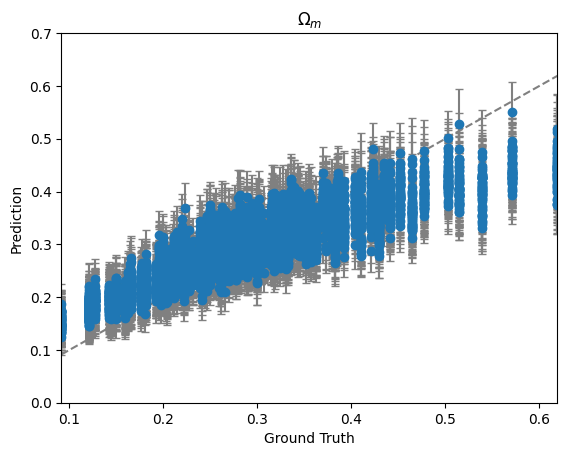

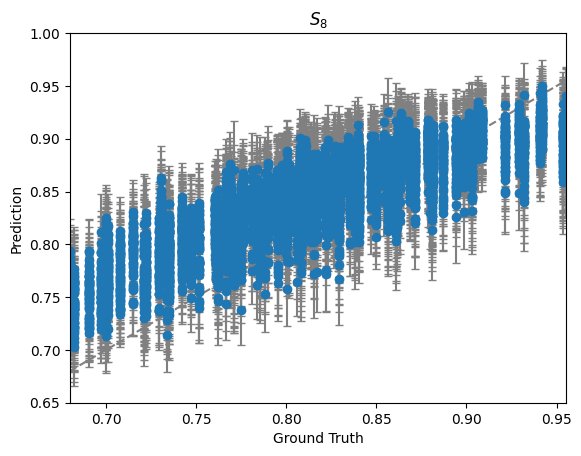

In [42]:
# Comparison of the means & standard deviations of the posterior distributions and the validation labels

plt.errorbar(y_val[:,0], mean_val[:,0], yerr=errorbar_val[:,0],
             fmt='o', capsize=3, capthick=1, ecolor='grey')
plt.plot(sorted(y_val[:,0]), sorted(y_val[:,0]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,0]), np.max(y_val[:,0]))
plt.ylim(0, 0.7)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$\Omega_m$')
plt.show()

plt.errorbar(y_val[:,1], mean_val[:,1], yerr=errorbar_val[:,1],
             fmt='o', capsize=3, capthick=1, ecolor='grey')
plt.plot(sorted(y_val[:,1]), sorted(y_val[:,1]),
         color = 'grey', linestyle='dashed')
plt.xlim(np.min(y_val[:,1]), np.max(y_val[:,1]))
plt.ylim(0.65, 1)
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.title(r'$S_8$')
plt.show()

In [48]:
validation_score = Score._score_phase1(
    true_cosmo=y_val,
    infer_cosmo=mean_val,
    errorbar=errorbar_val
)
print('averaged score:', np.mean(validation_score))
print('averaged error bar:', np.mean(errorbar_val, 0))

non_zero_mask = y_val != 0
percentage_error_masked = np.full_like(y_val, np.nan)  # Initialize with NaN
percentage_error_masked[non_zero_mask] = (y_val[non_zero_mask] - mean_val[non_zero_mask]) / y_val[non_zero_mask] * 100

# Calculate mean percentage error (NaN values are automatically ignored)
mean_percentage_error_masked = np.nanmean(percentage_error_masked, axis=0)

print(f"  Ω_m: {mean_percentage_error_masked[0]:.2f}%")
print(f"  S_8: {mean_percentage_error_masked[1]:.2f}%")
print(f"  Overall: {np.nanmean(percentage_error_masked):.2f}%")


# Save the validation score as a JSON file
scoring_output = {"validation_score": float(validation_score),
                  "num_val": Nval,
                  "num_train": Ntrain,
                 "Ω_m%error": mean_percentage_error_masked[0],
                "S_8%error":mean_percentage_error_masked[1]}

with open(f"scoring_output/{MODEL_NAME}.json", "w") as f:
    json.dump(scoring_output, f, indent=2)
0
print(f"Validation score saved to scoring_output/{MODEL_NAME}.json: {validation_score}")

averaged score: 4.784500614778278
averaged error bar: [0.04490138 0.03412149]
  Ω_m: -6.90%
  S_8: -3.93%
  Overall: -5.41%
Validation score saved to scoring_output/ResNetWithAttention_direct_baseline.json: 4.784500614778278


# 6 - Phase one inference

### Estimate the summary statistics $\boldsymbol{d}$ for all test data

In [44]:
test_dataset = CosmologyDataset(
    data=data_obj.kappa_test,
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [45]:
model.eval()
means_pred_list, sigmas_pred_list = [], []
pbar = tqdm(test_loader, total=len(test_loader), desc="Inference on the test set")
with torch.no_grad():
    for X in pbar:
        X = X.to(config.DEVICE)
        means_pred, sigmas_pred = model(X)
        means_pred_list.append(means_pred.cpu().numpy())
        sigmas_pred_list.append(sigmas_pred.cpu().numpy())

mean = np.concatenate(means_pred_list, axis=0)
mean = label_scaler.inverse_transform(mean)          # inverse transform

errorbar = np.concatenate(sigmas_pred_list, axis=0)
errorbar = errorbar*label_scaler.var_**0.5           # rescale by the training label std

Inference on the test set: 100%|██████████| 63/63 [05:13<00:00,  4.97s/it]


In [46]:
## Include the prior that the cosmological parameters are not negative
negative_mask = mean - errorbar < 0
errorbar[negative_mask] = mean[negative_mask]

#### ⚠️ NOTE:
- `mean`: a 2D array containing the point estimates of 2 cosmological parameters $\hat{\Omega}_m$ and $\hat{S}_8$.
- `errorbar`: a 2D array containing the one-standard deviation uncertainties of 2 cosmological parameters $\hat{\sigma}_{\Omega_m}$ and  $\hat{\sigma}_{S_8}$.

The shapes of `mean`, and `errorbar` must be $(N_{\rm test}, 2)$.

***

# 7 - (Optional) Prepare submission for Codabench

***

This section will save the model predictions `mean` and `errorbar` (both are 2D arrays with shape `(4000, 2)`, where `4000` is the number of test instances and `2` is the number of our parameters of interest) as a dictionary in a JSON file `result.json`. Then it will compress `result.json` into a zip file that can be directly submitted to Codabench.

***

In [47]:
data = {"means": mean.tolist(), "errorbars": errorbar.tolist()}
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
zip_file_name = f'Submission_{MODEL_NAME}' + the_date + '.zip'
zip_file = Utility.save_json_zip(
    submission_dir="submissions",
    json_file_name="result.json",
    zip_file_name=zip_file_name,
    data=data
)
print(f"Submission ZIP saved at: {zip_file}")

Submission ZIP saved at: submissions/Submission_ResNetWithAttention_direct_baseline25-09-17-00-23.zip
